# PilotNet SNN Example

Network excange module is available as `lava.lib.dl.netx.{hdf5, blocks, utils}`.
* `hdf5` implements automatic network generation.
* `blocks` implements individual layer blocks.
* `utils` implements hdf5 reading utilities. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io

from lava.lib.dl import netx
from dataset import PilotNetDataset

## Create network block

A network block can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

In [2]:
# net = netx.hdf5.Network(net_config='network.net')
net = netx.hdf5.Network(net_config='conv_only.net')
print(net)

{'shape': (200, 66, 3), 'neuron_params': {'neuron_proc': <class 'lava.proc.lif.process.LIF'>, 'vth': 25, 'du': 4095, 'dv': 1024, 'bias_exp': 6, 'use_graded_spikes': False}, 'transform': <function Network.create_input.<locals>.transform at 0x7f470c2b60d0>}
|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Input     |  200|   66|    3|     |     |     |     |     |False|
|Conv      |   99|   32|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   49|   15|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   48| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|  100|20, 2| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|   50| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|   10| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|
|Conv      |    1|    1|    1| 1, 1| 1, 1| 0, 0| 1, 1|    1|False|


In [3]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.__class__.__name__:5s} : {l.name:10s}, shape : {l.shape}')

There are 10 layers in network:
Input : Process_1 , shape : (200, 66, 3)
Conv  : Process_3 , shape : (99, 32, 24)
Conv  : Process_6 , shape : (49, 15, 36)
Conv  : Process_9 , shape : (24, 7, 48)
Conv  : Process_12, shape : (22, 4, 64)
Conv  : Process_15, shape : (20, 2, 64)
Conv  : Process_18, shape : (1, 1, 100)
Conv  : Process_21, shape : (1, 1, 50)
Conv  : Process_24, shape : (1, 1, 10)
Conv  : Process_27, shape : (1, 1, 1)


## Create Dataset instance
Typically the user would write it or provide it.

In [4]:
full_set = PilotNetDataset(
    path='../data', 
    transform=net.in_layer.transform, # input transform
    visualize=True, # visualize ensures the images are returned in sequence
)
train_set = PilotNetDataset(
    path='../data', 
    transform=net.in_layer.transform, # input transform
    train=True,
)
test_set = PilotNetDataset(
    path='../data', 
    transform=net.in_layer.transform, # input transform
    train=False,
)

## Run the network

In [5]:
num_samples = 201
steps_per_sample = 16
buffer = 1
readout_offset = (steps_per_sample-1) + (len(net.layers) - 1)

In [6]:
run_config = Loihi1SimCfg(select_tag='fixed_pt')

In [7]:
id = 10550
gts = []
results = []
for i in range(num_samples * (steps_per_sample + buffer)):
     # reset the network
     if i % (steps_per_sample + buffer) < len(net):
          # print(f'Resetting layer {i%(steps_per_sample + buffer)} at {i=}.')
          if i > 0:
               l = i % (steps_per_sample + buffer)
               net.layers[l].neuron.u.set(np.zeros(net.layers[l].neuron.shape))
               net.layers[l].neuron.v.set(np.zeros(net.layers[l].neuron.shape))
               # assert np.abs(net.layers[l].neuron.u.get()).sum() == 0
               # assert np.abs(net.layers[l].neuron.v.get()).sum() == 0
          if i % (steps_per_sample + buffer) == 0:
               image, gt = full_set[id]
               if i > 0:
                    net.in_layer.neuron.bias.set(image)
                    # assert np.abs(net.in_layer.neuron.bias.get() - image).sum() == 0
               else:
                    net.in_layer.neuron.bias.init = image
               gts.append(gt)
               id = id + 1

     # run the network
     net.run(condition=RunSteps(num_steps=1), run_cfg=run_config)

     # gather result
     if i % (steps_per_sample + buffer) == readout_offset % (steps_per_sample + buffer):
          results.append(net.out_layer.neuron.v.get())
          print(f'\rSample: {id}', end='')
     # results.append(net.out_layer.neuron.v.get())
bias = net.in_layer.neuron.bias.get()
net.stop()


Sample: 10556

Process SystemProcess-16:
Process SystemProcess-15:
Process SystemProcess-10:
Process SystemProcess-19:
Process SystemProcess-9:
Process SystemProcess-4:
Process SystemProcess-18:
Process SystemProcess-13:
Process SystemProcess-2:
Process SystemProcess-11:
Process SystemProcess-17:
Process SystemProcess-6:
Process SystemProcess-3:
Process SystemProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
Process SystemProcess-14:
Process SystemProcess-12:
Process SystemProcess-5:
Process SystemProcess-20:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Process SystemProcess-21:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multip

KeyboardInterrupt: 

In [ ]:
# # Dataloader
# interval = steps_per_sample + buffer

# # bias loader
# dataloader = io.dataloader.StateDataLoader(
#     dataset=full_set, interval=interval,
#     startId=10550 # TODO: something to tell the datloader to start from 10550
# )
# dataloader.connect_var(net.in_layer.neuron.bias)

# # spike loader
# dataloader = io.dataloader.SpikeDataLoader(
#     dataset=full_set, interval=interval,
#     startId=10550 # TODO: something to tell the datloader to start from 10550
# )
# dataloader.s_out.connect(net.in_layer.inp)

# # voltage output
# output = io.sink.Read(buffer=num_samples, interval=interval, offset=readout_offset)
# output.connect_var(net.out_layer.neuron.v)

# # spike output
# output = io.sink.RingBuffer(shape=net.out_layer.neuron.shape, buffer=num_samples)
# net.out_layer.neuron.v.connect(output.a_in)

# # reset
# for i, l in enumerate(net.layers):
#     # Execution hangs when both u and v are reset
#     u_resetter = io.reset.Reset(interval=interval, offset=i)
#     v_resetter = io.reset.Reset(interval=interval, offset=i)
#     u_resetter.connect_var(l.neuron.u)
#     v_resetter.connect_var(l.neuron.v)

# net.run(condition=RunSteps(num_samples * interval), run_cfg=run_config)
# out = output.data.get()  # [1, 1, 1, 200]
# net.stop()

# # visualization process

## Evaluate Results

In [ ]:
results = np.array(results).flatten()/steps_per_sample/32/64
gt = np.load('3x3pred.npy')

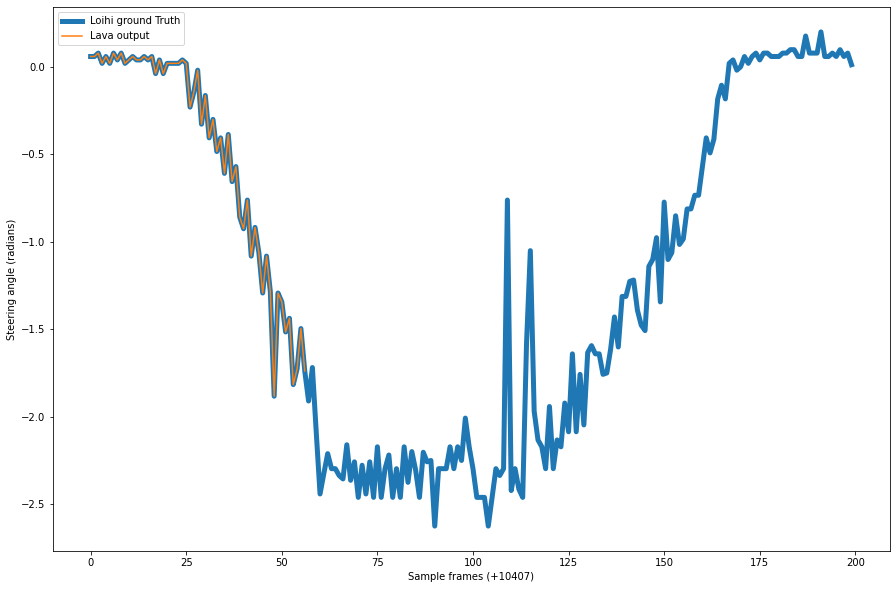

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(gt, linewidth=5, label='Loihi ground Truth')
plt.plot(results[1:], label='Lava output')
plt.xlabel(f'Sample frames (+{id-num_samples})')
plt.ylabel('Steering angle (radians)')
plt.legend()

In [ ]:
error = np.sum((gt - results[1:])**2)
print(f'{error=}')

error=0.0
